In [1]:
# CS 4680 Project 2 - Zoom Stock Time Series Analysis
# Roman Bravo, Erik Correa, Sergio Figueroa, Tallal Moshrif
# May 1 2022
# Description: The purpose of this project is to build a forecast model for the stock Zoom (Ticker: ZM)

In [2]:
# Install yfinance
!pip install yfinance

In [3]:
# Import libraries
import yfinance as yf
import pandas as pd

In [241]:
# Zoom Video Communications Inc (ZM) - Import Stock data
zm = yf.Ticker('ZM')
zm_hist = zm.history(period='max', auto_adjust = True)
zm_hist.shape

(774, 7)

In [242]:
# Create Dataframe for ZM
zm_df = pd.DataFrame()
#zm_df['ds'] = zm_hist.index # Commented out due to ds issue
zm_df['date'] = zm_hist.index
zm_df['y'] = zm_hist['Close'].values
zm_df.tail()

,date,y
769,2022-05-06,96.379997
770,2022-05-09,92.339996
771,2022-05-10,90.680000
772,2022-05-11,84.800003
773,2022-05-12,84.970001


In [6]:
# Forecast For Next Quarter using fbprophet
from fbprophet import Prophet

In [7]:
# Fit zm_df to fbprophet object
m = Prophet(daily_seasonality = True)
m.fit(zm_df)

In [8]:
# Forecast 1 quarter into the future
future = m.make_future_dataframe(120, freq='B')
forecast = m.predict(future)

In [9]:
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
889,2022-10-21,43.143603,-32.122579,108.884234
890,2022-10-24,39.384303,-37.254287,105.832294
891,2022-10-25,37.433310,-46.783088,108.984431
892,2022-10-26,34.711552,-43.429285,106.079117
893,2022-10-27,32.588921,-51.311537,100.895755


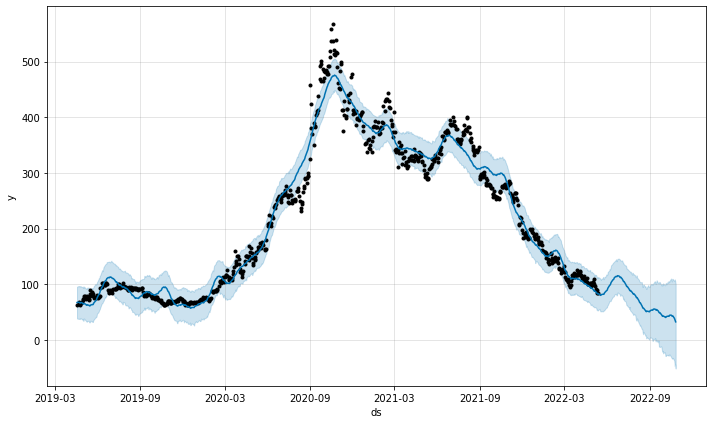

In [10]:
# Visualize the data up to one quarter ahead (May 2022 - September 2022)
m.plot(forecast);

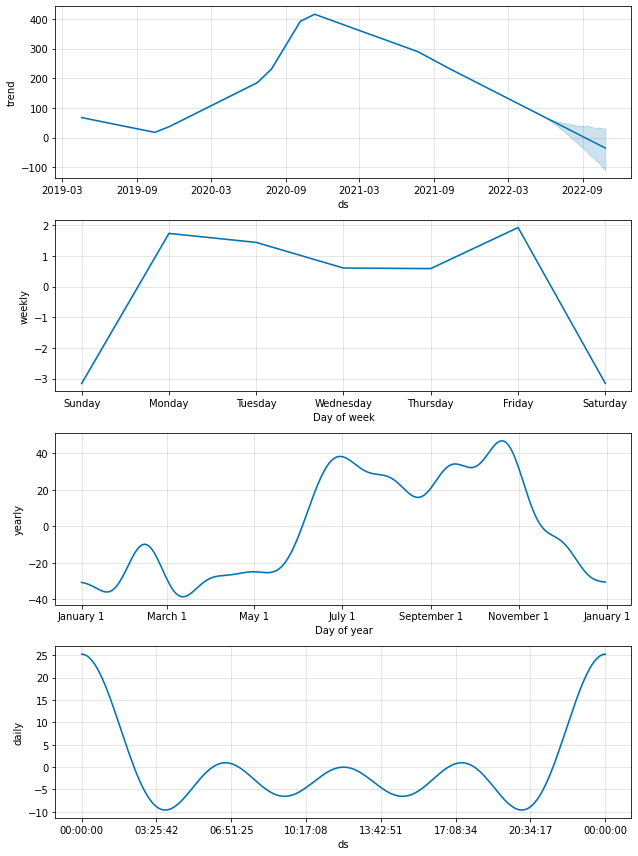

In [11]:
m.plot_components(forecast);

In [12]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='580 days', period='120 days', horizon = '365 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-01-12 00:00:00 and 2021-05-12 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,979.696352,31.300101,22.805528,0.057639,0.047781,0.70
1,38 days,1025.901351,32.029695,23.579619,0.059265,0.047781,0.68
2,40 days,1034.349657,32.161307,23.839116,0.059957,0.049894,0.68
3,41 days,1057.993887,32.526818,24.412108,0.061416,0.052098,0.64
4,42 days,1089.148301,33.002247,25.447851,0.064090,0.052762,0.62


Mostly Troubleshooting

In [249]:
zm_df.index

PeriodIndex(['2019-04-18', '2019-04-22', '2019-04-23', '2019-04-24',
             '2019-04-25', '2019-04-26', '2019-04-29', '2019-04-30',
             '2019-05-01', '2019-05-02',
             ...
             '2022-04-29', '2022-05-02', '2022-05-03', '2022-05-04',
             '2022-05-05', '2022-05-06', '2022-05-09', '2022-05-10',
             '2022-05-11', '2022-05-12'],
            dtype='period[B]', name='date', length=774)

In [244]:
zm_df = zm_df.groupby('date').sum()

In [246]:
zm_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 774 entries, 2019-04-18 to 2022-05-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       774 non-null    float64
dtypes: float64(1)
memory usage: 12.1 KB


In [247]:
zm_df

,y
date,
2019-04-18,62.000000
2019-04-22,65.699997
2019-04-23,69.000000
2019-04-24,63.200001
2019-04-25,65.000000
...,...
2022-05-06,96.379997
2022-05-09,92.339996
2022-05-10,90.680000


In [133]:
#zm_df.isnull().sum()

y    0
dtype: int64

In [169]:
#zm_df = zm_df.loc[~(zm_df==0).all(axis=1)]

In [180]:
#zm_df = zm_df.resample(rule = 'D').sum()

In [240]:
#zm_df.index = pd.DatetimeIndex(zm_df.index).asfreq('D', method = 'ffill')

AttributeError: ignored

In [248]:
zm_df = zm_df.set_index(zm_df.index).to_period('B')

In [174]:
#zm_df.index.asfreq = 'D'

In [52]:
#zm_df.set_index('ds', inplace=True)

Back to Modeling

In [250]:
# Train and Test Data Sets - Split 75 / 25
len(zm_df)

774

In [251]:
train_data = zm_df.iloc[:580] # Goes up to but not including 580
test_data = zm_df.iloc[580:]

In [252]:
len(train_data), len(test_data)

(580, 194)

In [268]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(endog = train_data['y'],trend='add',seasonal='mul',seasonal_periods=260).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [269]:
test_predictions = fitted_model.forecast(194).rename('HW Forecast')

In [270]:
test_predictions

2021-08-06    392.505354
2021-08-09    386.861920
2021-08-10    385.349162
2021-08-11    381.746304
2021-08-12    377.000208
                 ...    
2022-04-28    366.626067
2022-04-29    371.629592
2022-05-02    362.477389
2022-05-03    367.370594
2022-05-04    365.073844
Freq: B, Name: HW Forecast, Length: 194, dtype: float64

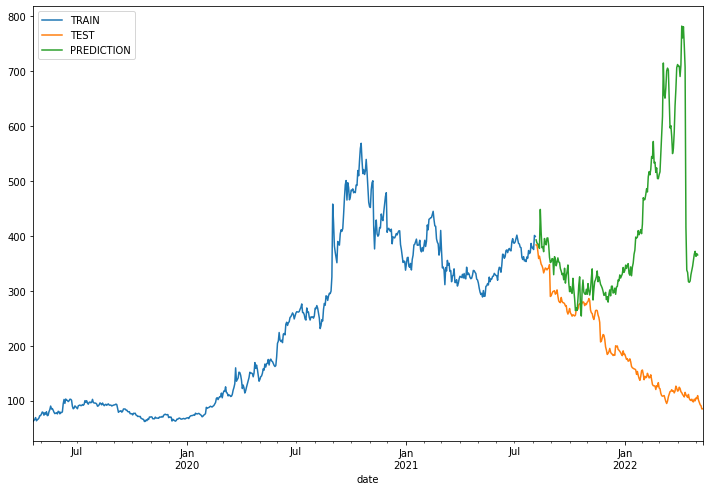

In [271]:
train_data['y'].plot(legend=True,label='TRAIN')
test_data['y'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

In [272]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [273]:
mean_absolute_error(test_data,test_predictions)

205.8126874053922

In [274]:
mean_squared_error(test_data,test_predictions)

77510.76447310833

In [266]:
np.sqrt(mean_squared_error(test_data,test_predictions))

NameError: ignored

In [267]:
test_data.describe()

,y
count,194.000000
mean,199.514845
std,80.997159
min,84.800003
25%,122.112497
50%,184.089996
75%,272.697495
max,383.470001
